# Exploratory Data Analysis of Pro-Level League of Legends Matches
***

The data being used was obtained from [Oracle's Elixer] (using upload from September 18th). A [codebook] for the variables is also included.

[Oracle's Elixer]: http://oracleselixir.com/match-data/
[codebook]: http://oracleselixir.com/match-data/match-data-dictionary/

## Getting the data and preparing the workspace

First I will import all neccessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

Then I will download a series of .xlsx links, read them into a pandas dataframe and concatenate them together. I will also save this initial dataset for reproducibility (and for consistency in the event the original .xlsx files are updated as I build out my analysis).

In [175]:
# List of excel file url's to read and join together
root_url = "http://oracleselixir.com/gamedata/"
urls = ["2016-spring/", "2017-spring/", "2017-summer/"]
urls = [root_url + url for url in urls]

partial_dfs = [pd.read_excel(url, 'Sheet1') for url in urls]
df = pd.concat(partial_dfs, ignore_index = True)

# Save df as a csv for future work.
# df.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Raw-LoL-Data.csv')

# Read df from csv if the files have been updated.
# df = pd.read_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Raw-LoL-Data.csv')

## Processing the data
***
I'll take a quick look at the dataset.

In [245]:
print(df.head(10))
print(df.info())

    gameid                                                url league   split  \
0  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
1  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
2  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
3  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
4  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
5  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
6  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
7  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
8  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
9  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   

           date  week game patchno playerid  side   ...         cspm goldat10  \
0  42578.113113  10.3    1    6.14    

As there are 33 object type columns that correspond to either numeric or categorical variables, they need to be recast for analysis. There are also two numeric types (patchno and playerid) that need to be coerced to categorical variables.

In [178]:
#Filter object type columns that will be converted to numeric.
objCols = df.columns[df.dtypes == object][16:]

for col in objCols:
    try:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    except:
        print('Column {} cannot be converted to numeric.'.format(col))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null object
split                      64692 non-null object
date                       57937 non-null float64
week                       64692 non-null object
game                       64692 non-null object
patchno                    64692 non-null float64
playerid                   64692 non-null int64
side                       64692 non-null object
position                   64692 non-null object
player                     64692 non-null object
team                       64692 non-null object
champion                   64692 non-null object
ban1                       64506 non-null object
ban2                       64626 non-null object
ban3                       64518 non-null object
ban4                       35874 non-null object
ban5    

In [179]:
#Filter object type columns that will be converted to categorical dtype.
objCols = list(df.columns[df.dtypes == object][2:16])
objCols += ['patchno', 'playerid']
print(objCols)

for col in objCols:
    try:
        df[col] = df[col].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))
print(df.info())

['league', 'split', 'week', 'game', 'side', 'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'patchno', 'playerid']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null category
split                      64692 non-null category
date                       57937 non-null float64
week                       64692 non-null category
game                       64692 non-null category
patchno                    64692 non-null category
playerid                   64692 non-null category
side                       64692 non-null category
position                   64692 non-null category
player                     64692 non-null category
team                       64692 non-null category
champion                   64692 non-null category
ban1                       64506 

#### NOTE - 'date' column conversion error:

The 'date column was originally being read as a float. My guess was that this meant pandas was taking a date like 2017/04/23 and interpretting it as: $\frac{2017}{\frac{4}{23}} $

I attempted to read in the 'date' column as a string to see how it was formatted so that I would know the correct parsing syntax to read it as a datetime. However, the problem with the date showing up as a float still remained. I tried looking at the column in one of the smaller .xlsx files directly and the problem was present even there, leading my to suspect the entire column was miscast when the dataset was created.

In [244]:
dateTest = pd.ExcelFile("http://oracleselixir.com/gamedata/2016-spring/")
rows = dateTest.book.sheet_by_index(0).nrows
nrows = 10
dateTestDF = pd.read_excel(dateTest, 'Sheet1', skip_footer = (rows - nrows - 1), usecols = ['date'], dtype = {'date': str})

print(dateTestDF)
print(dateTestDF.info())
print(type(dateTestDF.iloc[0,0]))

                date
0  42578.11311342593
1  42578.11311342593
2  42578.11311342593
3  42578.11311342593
4  42578.11311342593
5  42578.11311342593
6  42578.11311342593
7  42578.11311342593
8  42578.11311342593
9  42578.11311342593
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
date    10 non-null object
dtypes: object(1)
memory usage: 160.0+ bytes
None
<class 'str'>


***
#### Segmenting the data:

Now that the column data types have been properly coerced, I will split the data into two separate data frames - one for team level data and the other for individual player data.

In [39]:
teamDF = df[df['player'] == 'Team']
playerDF = df[df['player'] != 'Team']

## Exploratory Data Analysis
***

I'll start by looking at a heatmap of the correlation matrix for `teamDF`. It appears there are a lot of strongly correlated variables, but it's difficult to see which they are due to the large number of variables.

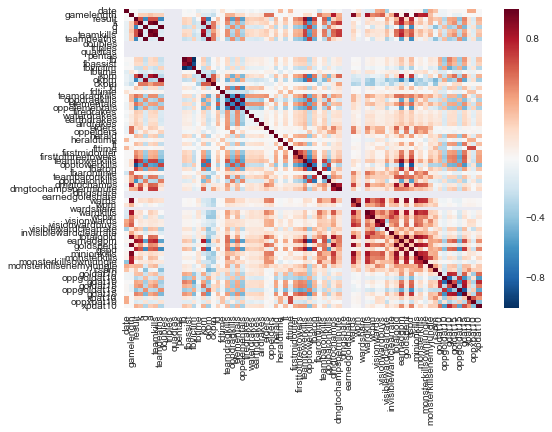

In [40]:
corr = teamDF.corr()
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

I'd like to reduce the number of columns I'm using to get a clearer picture. Rather than looking at all of the individual correlations between columns, I'm mostly interested in how the columns correlate with the 'result' column.

First I'll explore this numerically, to see which columns are the most strongly correlated to the response.

In [246]:
print(teamDF.corrwith(teamDF[['result']]))

a                       NaN
airdrakes               NaN
ckpm                    NaN
cspm                    NaN
d                       NaN
date                    NaN
dmgshare                NaN
dmgtochamps             NaN
dmgtochampsperminute    NaN
doubles                 NaN
earnedgoldshare         NaN
earnedgpm               NaN
earthdrakes             NaN
elders                  NaN
elementals              NaN
fb                      NaN
fbaron                  NaN
fbarontime              NaN
fbassist                NaN
fbtime                  NaN
fbvictim                NaN
fd                      NaN
fdtime                  NaN
firedrakes              NaN
firstmidouter           NaN
firsttothreetowers      NaN
ft                      NaN
fttime                  NaN
gamelength              NaN
gdat10                  NaN
                       ... 
oppdragkills            NaN
oppelders               NaN
oppelementals           NaN
oppgoldat10             NaN
oppgoldat15         

Unfortunately, (I think) because the 'result' column contains binary categorical data, the default pearson correlation method doesn't work here.

Instead, I'll try to look at correlation through Point-Biserial Correlation Coefficient.

In [87]:
# After lots of headbanging, I realized that Point-Biserial won't work for comparing
# dichotomous data with an array of object type. For now I've just dropped all columns
# of that type from the correlation analysis. But I'll revisit this later, as there are
# definitely important, potential predictors being dropped.

numCols = teamDF.columns[teamDF.dtypes == np.number]

corrResult = [stats.pointbiserialr(teamDF[['result']][pd.notnull(teamDF[col])], teamDF[[col]][pd.notnull(teamDF[col])])[0] for col in numCols]
corrResult = [n[0] for n in corrResult]
corrResult = pd.Series(corrResult, index = numCols)
corrResult = corrResult.dropna()
print(corrResult.sort_values())

opptowerkills             -0.882038
okpm                      -0.658117
oppbaronkills             -0.600284
oppdragkills              -0.544083
oppelementals             -0.541514
oppgoldat15               -0.413154
oppgoldat10               -0.291724
fbvictim                  -0.223947
oppelders                 -0.174521
oppxpat10                 -0.150927
date                       0.000000
fttime                     0.000000
heraldtime                 0.000000
fbarontime                 0.000000
fdtime                     0.000000
ckpm                       0.000000
gamelength                 0.000000
fbtime                     0.000000
visionwardbuys             0.004010
wards                      0.010475
monsterkillsownjungle      0.014367
visionwards                0.025927
wpm                        0.039214
minionkills                0.045806
wardkills                  0.119385
invisiblewardclearrate     0.135190
xpat10                     0.150927
elders                     0

C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3016: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\glander\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3017: RuntimeWarning: Mean of empty slice.
  my = y.mean()
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in less
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x =

Finally, we can create a readable heatmap for the features most correlated (positively and negatively) with result.

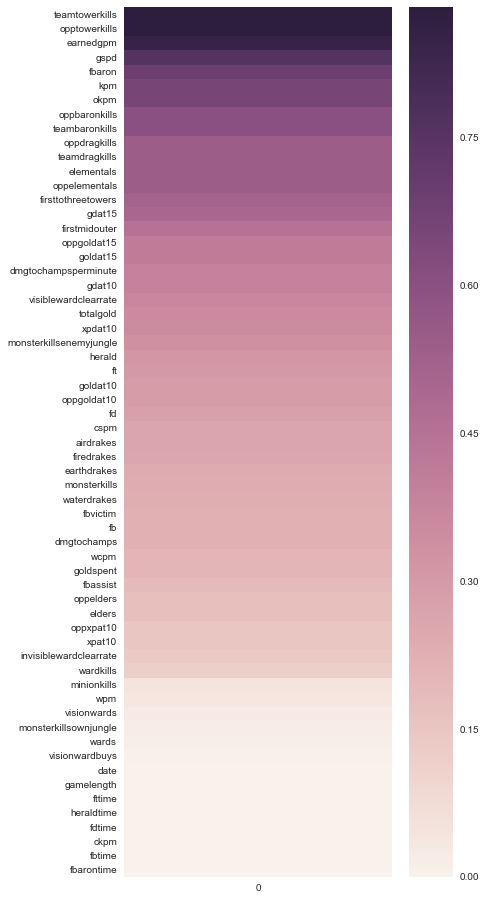

In [136]:
plt.figure(figsize=(6, 16))
sb.heatmap(pd.DataFrame(abs(corrResult)).sort_values(by = 0, ascending = False))
plt.show()

### Further processing the data
***

Next we will look at the team data grouped by unique teams.

In [138]:
teamRecords = teamDF[['result']].groupby(teamDF['team']).mean()

teamRecords.columns = ['winPct']

print(teamRecords.sort_values(by = 'winPct').head(20))

print(teamRecords.sort_values(by = 'winPct').tail(20))

                      winPct
team                        
Eanix               0.000000
Team Gates          0.000000
Besiktas            0.000000
T Show E-Sports     0.000000
Seoul City          0.000000
RisingStar Gaming   0.000000
Chungcheongnam      0.000000
Cougar eSports      0.035714
Hyper Youth Gaming  0.090909
Mousesports         0.100000
Team Mist           0.107143
Kaos Latin Gamers   0.142857
Delta Fox           0.181818
Mysterious Monkeys  0.194444
Fire Ball           0.196970
Enemy               0.200000
Nerv                0.200000
SK Gaming           0.200000
SBENU Sonicboom     0.204545
Cilekler            0.214286
                       winPct
team                         
Hard Random          0.625000
KT Rolster           0.626126
INTZ                 0.630137
J Team               0.631579
RED Canids           0.631579
Immortals            0.644068
Royal Never Give Up  0.648352
G2 Esports           0.651282
Team oNe e-Sports    0.652174
SuperMassive         0.654762
IN

I'll store team win percentages in new columns for later analysis.

In [186]:
teamDF["winRate"] = teamDF["team"].map(teamRecords['winPct'])
playerDF["teamWinRate"] = playerDF["team"].map(teamRecords['winPct'])

In [223]:
teamFreq = teamDF['team'].value_counts()
print(teamFreq.describe())

playerFreq = playerDF['player'].value_counts()
print(playerFreq.describe())
print(playerFreq[:15])

count    161.000000
mean      66.968944
std       63.597113
min        1.000000
25%       16.000000
50%       42.000000
75%      101.000000
max      261.000000
Name: team, dtype: float64
count    995.000000
mean      54.180905
std       56.133997
min        0.000000
25%       10.000000
50%       32.000000
75%       83.000000
max      261.000000
Name: player, dtype: float64
count       12.000000
mean      4492.500000
std       3132.314639
min          0.000000
25%       4578.000000
50%       4578.000000
75%       4578.000000
max      12708.000000
Name: playerid, dtype: float64
Wolf          261
Bang          261
Faker         260
Arrow         228
Smeb          226
Ssumday       223
Crown         223
Darshan       223
Score         221
Stixxay       221
CuVee         219
Hauntzer      213
Bjergsen      213
Svenskeren    213
Xmithie       210
Name: player, dtype: int64
1      12708
10      4578
9       4578
8       4578
7       4578
6       4578
5       4578
4       4578
3       4578
2  

In [227]:
teamDF['totalGames'] = teamDF.groupby('team')['team'].transform('count')
playerDF['totalGames'] = playerDF.groupby('player')['player'].transform('count')

94
                    team  totalGames
10            KT Rolster         222
11        Longzhu Gaming         180
22              ESC Ever          55
23         SK Telecom T1         261
34        Afreeca Freecs         212
35            ROX Tigers         206
46            KT Rolster         222
47         SK Telecom T1         261
58                  INTZ          73
59           g3nerationX          16
70       Kongdoo Monster         109
71            KT Rolster         222
82     Copenhagen Wolves          23
83                  Huma          42
94              CJ Entus         101
95         SK Telecom T1         261
106        SK Telecom T1         261
107             CJ Entus         101
118       Afreeca Freecs         212
119           KT Rolster         222
130           KT Rolster         222
131       Afreeca Freecs         212
142               Fnatic         167
143               Origen         115
154             Elements          18
155           G2 Esports         19

In [231]:
print(playerDF['totalGames'].describe())
print(teamDF['totalGames'].describe())

count    53910.000000
mean       112.279948
std         62.532972
min          1.000000
25%         59.000000
50%        109.000000
75%        158.000000
max        261.000000
Name: totalGames, dtype: float64
count    10782.000000
mean       126.988870
std         68.038101
min          1.000000
25%         67.000000
50%        133.000000
75%        182.000000
max        261.000000
Name: totalGames, dtype: float64


We will examine if starting side appears to have an effect on result.

In [68]:
sideResult = teamDF[['result']].groupby(teamDF['side']).mean()

print(sideResult)

        result
side          
Blue  0.558523
Red   0.441477


There definitely appears to be an effect. Let's try a 2 sample t-test for significance at 95% confidence ( $ \alpha = 0.05 $).

In [147]:
blue = teamDF[teamDF['side'] == 'Blue']['result']
red = teamDF[teamDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))

Ttest_indResult(statistic=12.236716198327914, pvalue=3.335296975431772e-34)


With a pvalue remarkabley smaller than our $/alpha$, we can confidently say that in the great battle of red vs blue, blue wins!

With such a strong effect from starting side, we now have more questions than answers. Why does starting side act as such a strong determinant in outcome? With some domain knowledge of the game, there are a couple of theories to consider. Since blue side gets first pick of champions, they have the ability to pick up the most powerful champion to slip through bans.

The blue side team, because of the map layout, also has certain in game advantages and weaknesses in terms of dragon and baron control.

So the real question we're trying to answer is - Does blue side win more often because of an in-game advantage in map layout, or does it win more because of a pre-game advantage in the picks and bans phase.
One of the strongly correlated features with result we saw earlier was 'fb' (First Blood). This column is marked with a one for teams that draw first blood (make the first kill against their opponent), and a zero otherwise. Since first blood generally occurs before dragon and baron control have influenced the game, it might be a good place to start this examination. If the blue side is outperforming the red side in first blood, it would not be unreasonable to think that their advantage is coming from picks and bans.

In [88]:
fbBySide = teamDF[['fb']].groupby(teamDF['side']).mean()

print(fbBySide)

            fb
side          
Blue  0.522395
Red   0.477605


Indeed, blue side appears to draw first blood more often than red. Let's do a similar test for significance as before, again with $\alpha = 0.05$.

In [158]:
blue = teamDF[teamDF['side'] == 'Blue']['fb']
red = teamDF[teamDF['side'] == 'Red']['fb']

print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

Ttest_indResult(statistic=4.2576111713038545, pvalue=2.0871668499470614e-05)


Again we can say there is significance to first blood being more likely to be drawn by blue side.

#### NOTE: I will finish this examination of side influence later. I plan to test for significance given the win pct of team, (using cut to mask win pct as a categorical variable of quartiles). I might also try to evaluate side effect through in-game variables, like jungle camps cleared and opp jungle camps, to see if there is a side advantage to the jungler that is influencing first blood rate.

I will add a quantile cut of winRate into teamDF.

In [263]:
# test = teamDF
# test['quality'] = test.groupby('team')['winRate'].transform(
#                 lambda x: pd.qcut(x, q=5, labels = ['Bad', 'Poor', 'Fair', 'Good', 'Great']))
# print(test[['team', 'winRate','quality']].head(30))

temp = teamDF[['team','winRate']].groupby('team').mean()
temp['quality'] = pd.qcut(temp['winRate'], q = 5, labels = ['Bad', 'Poor', 'Fair', 'Good', 'Great'])
teamDF["quality"] = teamDF["team"].map(temp['quality'])
print(teamDF[['team', 'winRate','quality']].head(10))

              team   winRate quality
10      KT Rolster  0.626126   Great
11  Longzhu Gaming  0.511111    Good
22        ESC Ever  0.418182    Fair
23   SK Telecom T1  0.693487   Great
34  Afreeca Freecs  0.495283    Fair
35      ROX Tigers  0.597087   Great
46      KT Rolster  0.626126   Great
47   SK Telecom T1  0.693487   Great
58            INTZ  0.630137   Great
59     g3nerationX  0.312500    Poor


I'll now do the same thing with the 'gamelength' column.

In [266]:
teamDF['pace'] = pd.qcut(teamDF['gamelength'], q = 5, labels = ['Sprint', 'Trot', 'Walk', 'Amble', 'Crawl'])
print(teamDF[['team', 'gamelength','pace']].head(10))

              team  gamelength    pace
10      KT Rolster   42.683333   Crawl
11  Longzhu Gaming   42.683333   Crawl
22        ESC Ever   41.366667   Amble
23   SK Telecom T1   41.366667   Amble
34  Afreeca Freecs   32.900000    Trot
35      ROX Tigers   32.900000    Trot
46      KT Rolster   33.100000    Trot
47   SK Telecom T1   33.100000    Trot
58            INTZ   22.716667  Sprint
59     g3nerationX   22.716667  Sprint


And the same transformation once more with the 'ckpm' (combined kills per minute) column.

In [268]:
teamDF['aggression'] = pd.qcut(teamDF['ckpm'], q = 5, labels = ['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'])
print(teamDF[['team', 'ckpm', 'aggression']].head(10))

              team      ckpm aggression
10      KT Rolster  0.210855       Calm
11  Longzhu Gaming  0.210855       Calm
22        ESC Ever  0.652699   Moderate
23   SK Telecom T1  0.652699   Moderate
34  Afreeca Freecs  1.094225       Wild
35      ROX Tigers  1.094225       Wild
46      KT Rolster  0.604230      Alert
47   SK Telecom T1  0.604230      Alert
58            INTZ  1.144534       Wild
59     g3nerationX  1.144534       Wild


Now that I've derived these additional columns, let's explore how they relate to one another.

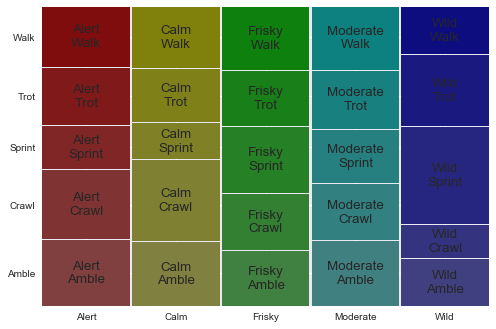

In [275]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 16.0
mosaic(teamDF, ['aggression', 'pace']);
plt.show()

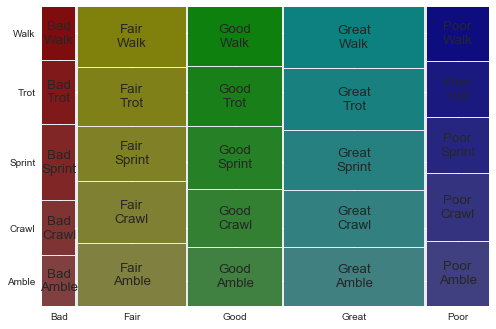

In [276]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(teamDF, ['quality', 'pace']);
plt.show()

In [293]:
teamDF['quality'].cat.reorder_categories(['Bad', 'Poor', 'Fair', 'Good', 'Great'], ordered=True, inplace = True)
teamDF['pace'].cat.reorder_categories(['Sprint', 'Trot', 'Walk', 'Amble', 'Crawl'][::-1], ordered=True, inplace = True)
teamDF['aggression'].cat.reorder_categories(['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'], ordered=True, inplace = True)
print([teamDF[c].cat.categories for c in ['quality', 'pace', 'aggression']])

[Index(['Bad', 'Poor', 'Fair', 'Good', 'Great'], dtype='object'), Index(['Crawl', 'Amble', 'Walk', 'Trot', 'Sprint'], dtype='object'), Index(['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'], dtype='object')]


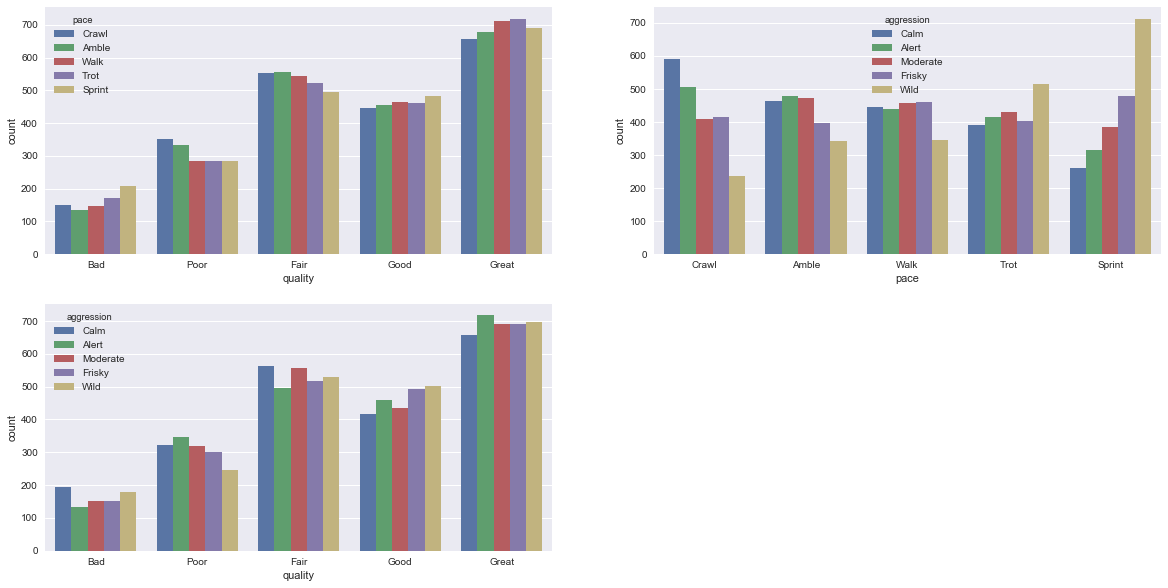

In [308]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax = sb.countplot(x="quality", hue="pace", data=teamDF)

plt.subplot(2,2,2)
ay = sb.countplot(hue="aggression", x="pace", data=teamDF)

plt.subplot(2,2,3)
ay = sb.countplot(hue="aggression", x="quality", data=teamDF)

plt.show()

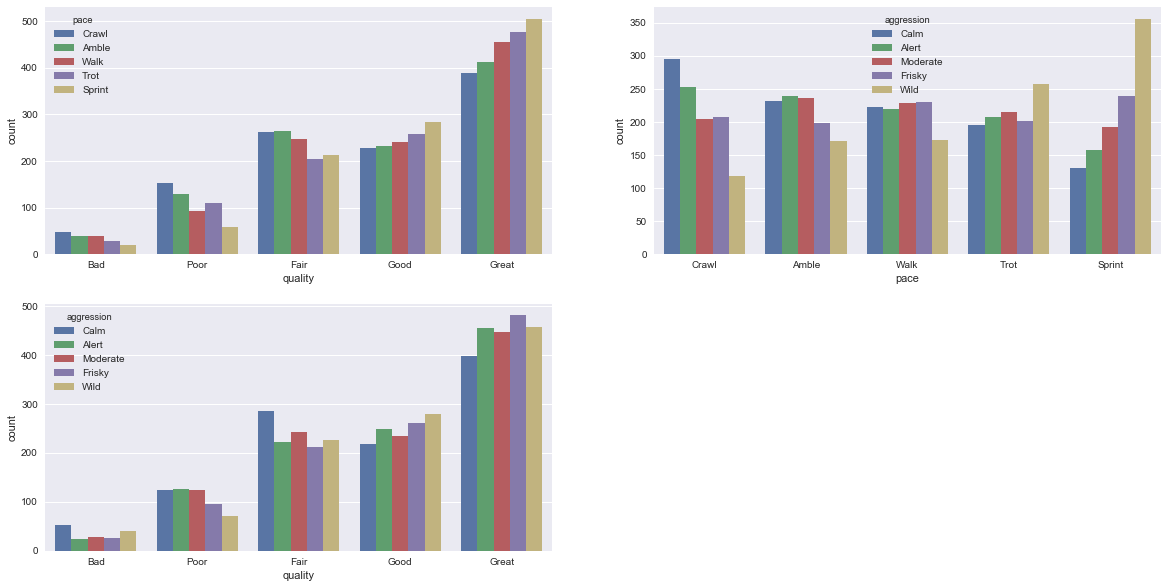

In [317]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax = sb.countplot(x="quality", hue="pace", data=teamDF[teamDF['result'] == 1])

plt.subplot(2,2,2)
ay = sb.countplot(hue="aggression", x="pace", data=teamDF[teamDF['result'] == 1])

plt.subplot(2,2,3)
ay = sb.countplot(hue="aggression", x="quality", data=teamDF[teamDF['result'] == 1])

plt.show()

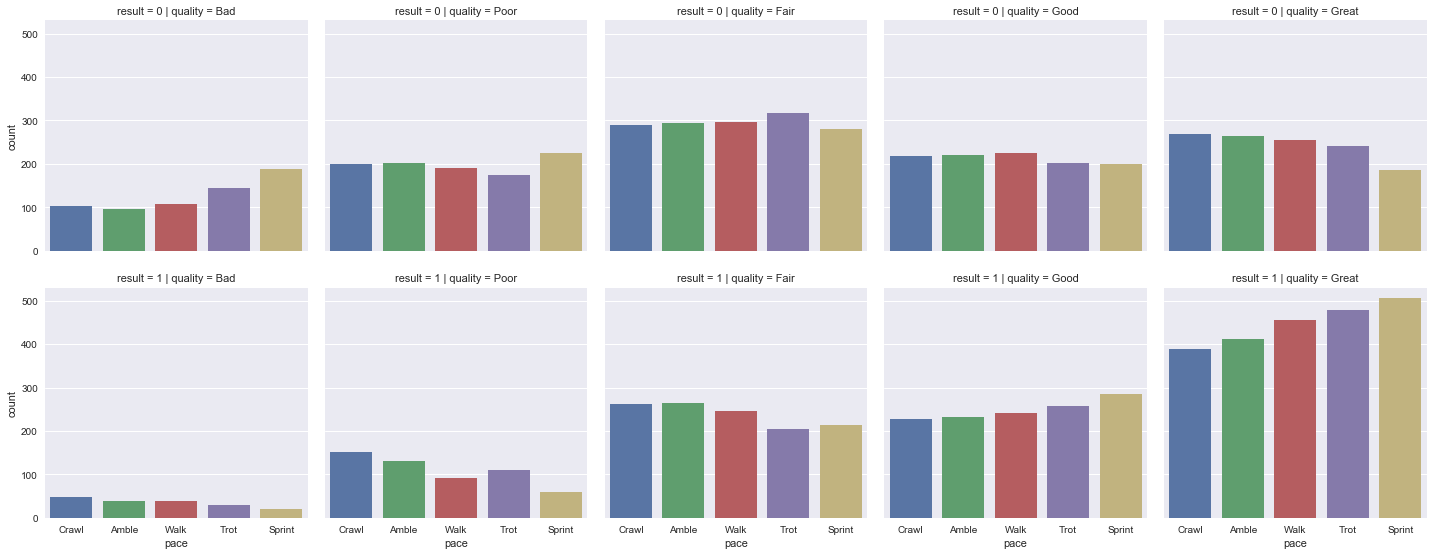

In [335]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="pace", col = 'quality', row = 'result', data=teamDF, kind = 'count');

plt.show()

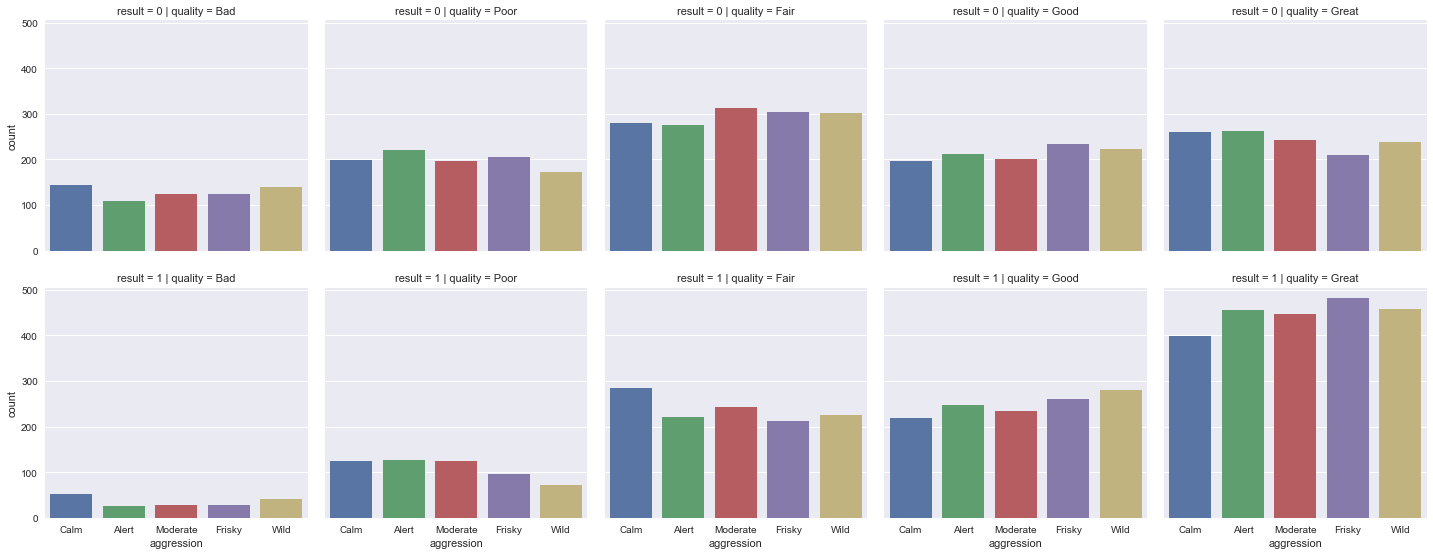

In [336]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="aggression", col = 'quality', row = 'result', data=teamDF, kind = 'count');

plt.show()

### Macro strategies to impact game outcome

I would like to investigate if there are playstyle strategies available to teams that will improve their likelihood of winning. In american football for instance, bad teams - meaning those with lower records - are statistically more likely to beat a good opponent by raising the variance of the game through things like trick plays, unexpected onside kicks, aggressive throw selection, 4th down calls, etc. I'm interested in seeing if there are extensions of this in competitive League of Legends.

For instance, are the best teams (top quartile of win pct) more or less likely to win longer games? The same question with 'bloodier' (high values for 'ckpm' - combined kills per minute) games.

First, let's get an idea of the distributions of gamelength and ckpm.

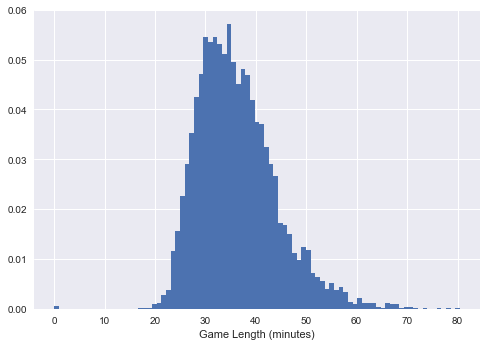

In [106]:
plt.hist(teamDF['gamelength'], bins = 'fd', normed = True)
plt.xlabel("Game Length (minutes)")
plt.show()

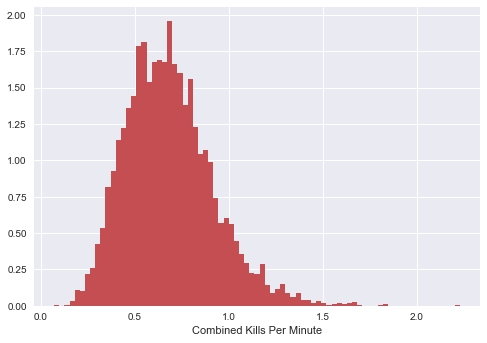

In [161]:
plt.hist(teamDF['ckpm'].dropna(), bins = 'fd', normed = True)
plt.xlabel("Combined Kills Per Minute")
plt.show()

In [162]:
#df.to_excel(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Merged-LoL-Data-Sep19.xlsx')

In [174]:
#df.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Merged-LoL-Data-Sep25.csv')